In [0]:
!python -V

Python 3.7.4


In [0]:
# !pip install feature-engine
# !pip install optuna
# # !pip install featexp
# !pip install catboost

In [0]:
from featexp import get_univariate_plots
from featexp import univariate_plotter
from featexp import get_trend_stats

# Load packages

In [0]:
import gc
import os
import pathlib
import re
import pandas as pd
import numpy as np
from numpy.linalg import svd
from numba import jit
import itertools
from copy import deepcopy
from contextlib import contextmanager
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline as pipe
from feature_engine import categorical_encoders as ce
from feature_engine import discretisers as dsc
import concurrent.futures

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import (cross_val_score, train_test_split, ShuffleSplit, StratifiedKFold, KFold,
                                    learning_curve, TimeSeriesSplit, RepeatedKFold)

from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
                             VotingClassifier, ExtraTreesClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from scipy import stats 
from scipy.special import boxcox1p

from scipy.stats import rankdata
from sklearn.preprocessing import (MinMaxScaler, Binarizer, StandardScaler, OneHotEncoder,
                                  Normalizer, RobustScaler, OrdinalEncoder, LabelEncoder)
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_metric
import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, RegressorMixin, clone

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 130)

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [0]:
colab_path = '/content/drive/My Drive/'
pickle.dump(mapper_fit, open('fitted_mapper.pkl', 'wb'))
# mapper_fit = pickle.load(open('fitted_mapper.pkl', 'rb'))

In [0]:
# with open( os.path.join(colab_path,'list_dict.json'), 'w') as fp:
#     json.dump(list_dicts, fp)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Functions

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_jobs = -1) # n_estimators=n_estimators, 
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist,
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)[:, 1]
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit) [:, 1]
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params) #iterations=n_estimators
                                      #loss_function='CrossEntropy') #  metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True, use_best_model=True, verbose=False) # cat_features=cats_indices

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

def make_harmonic_features(df, column):
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value, dtype='float32')
        df[col + '_sin'] = np.sin(value, dtype='float32')
    return (df)

def make_conj(data, feat1, feat2):
    """
    inplace
    """
    new_name = feat1 + '_' + feat2
    data[new_name] = data[feat1].astype(str)+ '_' + data[feat2].astype(str)
    data[new_name] = LabelEncoder().fit_transform(data[new_name])
    

# по значениям другого категориального признака
def code_factor(data, cat_feature, cat_feature2):
    ct = pd.crosstab(data[cat_feature], data[cat_feature2])
    u, _, _ = svd(ct.values)
    coder = dict(zip(ct.index, u[:, 0])) # если кодирование первой компонентой
    return (data[cat_feature].map(coder))

def make_real_feature(df, name, group_col='userid'):
    """
    вычисление разных статистик
    """
    tmp = df.groupby(group_col)[name].agg({np.mean, max, min, np.median, sum, np.std}).fillna(-1)
    tmp.columns = [name + '_' + str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    return (tmp[tmp.columns[tmp.nunique()>1]])


# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc', random_state=17)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt


def plot_learning_curve_roc(estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Количество объектов в выборке")
    plt.ylabel("ROC-AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=strat_kfold_5, n_jobs=n_jobs, train_sizes=train_sizes, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV")

    plt.legend(loc="best")
    return plt

def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()


def plot_roc(y_true, y_proba):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
    auc = metrics.roc_auc_score(y_true, res_dict['prediction'][:, 1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label=f"data 1, auc={auc:.4f}")
    plt.legend(loc=4)
    plt.show()


# Load dataset
def load_ottrip(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  data['userid'] = LabelEncoder().fit_transform(data.userid)
  data['USR_CNT'] = data.userid.map(data.groupby('userid').size())
  indicator_cols=list(filter(lambda x: 'indicat' in x, data.columns))
  data['INDICATOR_CNT'] = data[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data

def load_ottrip_without_userid_encoding(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  indicator_cols=list(filter(lambda x: 'indicat' in x, data.columns))
  data['INDICATOR_CNT'] = data[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data


def drop_corr_cols(df, upper_tresh=0.9):
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > upper_tresh)]

  return to_drop

colab_subm_path = '/content/drive/My Drive/ottrip_subm/'
colab_path = '/content/drive/My Drive/'


def feature_engineering(df, fna=0):

  df['DIFF_H']=abs(df['HOUR_DEPART']-df['HOUR_OF_BUY']).astype('int32')
  df['DIFF_M']=abs(df['MONTH_DEPART']-df['MONTH_BUY']).astype('int32')

  df['f14_id_median'] = df.userid.map(df.groupby('userid')['field14'].median().fillna(fna))
  df['f1_id_median'] = df.userid.map(df.groupby('userid')['field1'].median().fillna(fna))
  df['f1_id_std'] = df.userid.map(df.groupby('userid')['field1'].std().fillna(fna))
  df['f14_id_std'] = df.userid.map(df.groupby('userid')['field14'].std().fillna(fna))
  df['f27_id_median'] = df.userid.map(df.groupby('userid')['field27'].median().fillna(fna))
  df['f27_id_std'] = df.userid.map(df.groupby('userid')['field27'].std().fillna(fna))
  df['DAYS_BEFORE_DEPART_id_median'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].median().fillna(fna))
  df['DAYS_BEFORE_DEPART_id_std'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].std().fillna(fna))
  df['NDAYS_FROM_LAST_id_median'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].median().fillna(fna))
  df['NDAYS_FROM_LAST_id_std'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].std().fillna(fna))
 
  df['field13_id_median'] = df.userid.map(df.groupby('userid')['field13'].median().fillna(fna))
  df['field13_id_std'] = df.userid.map(df.groupby('userid')['field13'].std().fillna(fna))
  df['field26_id_median'] = df.userid.map(df.groupby('userid')['field26'].median().fillna(fna))
  df['field26_id_std'] = df.userid.map(df.groupby('userid')['field26'].std().fillna(fna))
  df['field19_id_median'] = df.userid.map(df.groupby('userid')['field19'].median().fillna(fna))
  df['field19_id_std'] = df.userid.map(df.groupby('userid')['field19'].std().fillna(fna))

  df = add_sem(df, group_col='userid', used_col=['field1'])
  df = add_sem(df, group_col='userid', used_col=['field14'])
  df = add_sem(df, group_col='userid', used_col=['field26'])
  df = add_sem(df, group_col='userid', used_col=['field27'])
  df = add_sem(df, group_col='userid', used_col=['field12'])
  df = add_sem(df, group_col='userid', used_col=['NDAYS_FROM_LAST'])
  df = add_sem(df, group_col='userid', used_col=['field13'])
  df = add_sem(df, group_col='userid', used_col=['field22'])
  df = add_sem(df, group_col='userid', used_col=['field25'])

  make_conj(df, 'field1', 'field14')
  make_conj(df, 'field26', 'field27')

  gr_col = ['YEAR', 'MONTH_DEPART', 'DOW_DEPART', 'HOUR_DEPART']
  df = add_aggregate(df, gr_col, 'userid', 'nunique', 'cnt_unq_depart')

  return reduce_mem_usage(df)


def add_sem(df, group_col, used_col):
  
  def sem_group(groupby):
     return groupby.sem()

  new_names = [name + '_sem' for name in used_col]
  dict_to_rename = dict(zip(used_col, new_names))
  tmp = df.groupby(group_col)[used_col].pipe(sem_group).fillna(-1).reset_index()\
            .rename(columns=dict_to_rename)
  tmp = tmp[tmp.columns[tmp.nunique()>1]]
  df = df.merge(tmp, on=group_col, how='left')
  return (df)

def add_quantile(df, group_col, used_col, 
                 quantile_list = [0.0, 0.25, 0.5, 0.75, 1.0]):
  
  tmp=df.groupby(group_col)[used_col].quantile(quantile_list).fillna(-1)  
  new_names = [used_col +'_'+ str(x) for x in quantile_list]
  dict_to_rename = dict(zip(quantile_list, new_names))                         
  tmp=tmp.unstack().reset_index().rename(columns=dict_to_rename)
  tmp=tmp[tmp.columns[tmp.nunique()>1]] 
  df=df.merge(tmp, on=group_col, how='left')
  return (df)

# def add_qlabels(df, group_col, used_col, qlabels=range(1,6)):
#   '''
#   inplace
#   '''
#   df[used_col+'_qlbs'] = df.groupby(group_col)[used_col].transform(
#                           lambda x: pd.qcut(x, len(qlabels), labels=qlabels))
  
def add_aggregate(df, group_col, used_col, func, suffix):
  tmp = df.groupby(group_col)[used_col].aggregate(func).reset_index()\
           .rename(columns={used_col: used_col + '_' + suffix})
  df = df.merge(tmp, on=group_col, how='left')
  return (df)


# def inv_scale(df, col):
#   col_sort = np.diff(np.sort(df[col].unique()))
#   c = Counter(col_sort)
#   most_common_div = np.round(c.most_common(10)[0][0], 5)
#   col_int = np.round(df[col] / most_common_div)
#   return (col_int + col_int.max())

def unique_cnt(x):
    return (len(np.unique(x)))

def cnt_(x):
    return (len(x))

def submit_predictions_task1(name, model, X_test):
    import pathlib
    PATH_TO_SAVE = pathlib.Path('/content/drive/My Drive/ottrip_subm/')

    pred_proba = model.predict_proba(X_test.values)[:, 1]

    df_submission = pd.DataFrame({'orderid': np.arange(len(X_test)), 
                                  'proba': pred_proba})
    
    submission_filename = 'subm_{}.csv'.format(name)
    df_submission.to_csv(PATH_TO_SAVE/submission_filename, index=False)

    print('Submission saved to {}'.format(submission_filename))


def load_submission(df_test, res, fname='sub1_1.csv'):
    
    df_subm = pd.DataFrame({'orderid': np.arange(len(df_test)), 
                            'proba': res})   
    colab_path = '/content/drive/My Drive/ottrip_subm/'           
    df_subm.to_csv( os.path.join(colab_path, fname), index=False )


def binar_cats(df, bin_dictionary):
    list_new_feats=[]
    for field, vect_values in bin_dictionary.items():
        new_name = 'f' + '_' + re.sub('\D', "", field)
        list_new_feats.append(new_name)
        df[new_name]=df[field].apply(lambda x: 1 if x in vect_values else 0).astype('category')
    print(f"There are {len(list_new_feats)} new binary feats in the data: {list_new_feats}")


SEED = 17
TEST_SIZE = 0.3
SPLITS = 10

# ==== cv strategy ====
shuffle_split = ShuffleSplit(n_splits=SPLITS, test_size=TEST_SIZE, random_state=SEED)
skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field19', 'USR_CNT',
            'field1_field14', 'field26_field27', 'field26']#+['field1', 'field14', 'TICKET_CHILD_1Y', 'field27']
drop_cols = ['orderid', 'userid', 'QUARTER']#, 'field1', 'field14', 'TICKET_CHILD_1Y', 'field26', 'field27'] 'indicator_goal21' 'indicator_goal22'

def combining_ds_stratagy(scaling=StandardScaler(), cols_to_scale=to_scale, cols_to_drop=drop_cols):                                  #scaling=StandardScaler(), cols_to_scale=to_scale, 
                          

    train = load_ottrip_without_userid_encoding()
    test = load_ottrip_without_userid_encoding(train=False)
    # print(f"Shape of raw data\ntrain: {train.shape}, test: {test.shape}")
    print('='*5)

    goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
    th = len(train)
    df_all = pd.concat([train.drop(columns=goals_cols+['goal1'],axis=1), test])
    print(f"Shape of combined data: {df_all.shape}")

    # gen features
    df_all['userid'] = LabelEncoder().fit_transform(df_all.userid)
    df_all['USR_CNT'] = df_all.userid.map(df_all.groupby('userid').size())
    df_all = feature_engineering(df_all)

    # # scaling
    df_all[cols_to_scale] = scaling.fit_transform(df_all[cols_to_scale])
    df_all = reduce_mem_usage(df_all, verbose=False)

    colsToRemove = []
    for col in df_all.columns:
      if df_all[col].std() == 0: 
           colsToRemove.append(col)

    df_all.drop(columns=colsToRemove, axis=1, inplace=True)
    print(f"colsToRemove: {colsToRemove}", ',')

    # split df_all
    X = df_all[:th].drop(cols_to_drop, axis=1)
    X_test = df_all[th:].drop(cols_to_drop, axis=1)
    X_test.reset_index(drop=True, inplace=True)
    targets = train.loc[:, ['goal1']+goals_cols]

    print('='*5)
    print(f"Shape of res data\nX: {X.shape}, X_test: {X_test.shape}, targets: {targets.shape}")

    return X, X_test, targets

# Load Data


In [0]:
colab_ott_train_path = pathlib.Path('/content/drive/My Drive/ott_train')
train = pd.read_pickle(colab_ott_train_path/'train.pkl')
test = pd.read_pickle(colab_ott_train_path/'test.pkl')
targets = pd.read_pickle(colab_ott_train_path/'targets.pkl')

In [0]:
df = load_ottrip()

df.head()

Mem. usage decreased to 15.71 Mb (75.4% reduction)
(196056, 45)


,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT
0,0,7458,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805
1,1,33232,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098
2,2,83136,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805
3,3,1583,0,-0.238651,10,11,1,1,3,0,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0,3,0.799805
4,4,93298,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0,1,0.600098


In [0]:
indicator_cols=list(filter(lambda x: 'indicat' in x, df.columns))
goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
cat_cols=['MONTH_BUY', 'MONTH_DEPART', 'field5', 'field7', 'field8',
 'field10', 'DOW_BUY', 'DOW_DEPART', 'YEAR', 'HOUR_DEPART', 'field27', 'QUARTER']+indicator_cols+goals_cols

to_harmonic_cols =['MONTH_BUY', 'MONTH_DEPART', 'HOUR_OF_BUY', 'HOUR_DEPART', 'DOW_BUY', 
                  'DOW_DEPART', 'QUARTER', 'field27']

to_ohe_cols = ['MONTH_BUY', 'MONTH_DEPART', 'HOUR_OF_BUY', 'HOUR_DEPART', 'DOW_BUY', 'DOW_DEPART', 'QUARTER', 'field27']

make_real_feats=['ORDER_OF_BUY', 'TICKET_CHILD_1Y', 'DAYS_BEFORE_DEPART',
       'DIFF_HOUR_DEPART&HOUR_OF_BUY', 'DIFF_MONTH_DEPART&MONTH_BUY',
       'field1', 'field12', 'field13', 'field14', 'field17', 'field19',
       'field22', 'field25', 'field26', 'field6', 'INDICATOR_CNT', 'NDAYS_FROM_LAST',
       'NDAYS_LAST_NEXT', 'TICKET_ADULT', 'TICKET_CHILD_4Y','TOTAL_TICKETS', 'USR_CNT', 'WEEKS_BEFORE_DEPART']

In [0]:
df_test = load_ottrip(train=False)

df_test.head()

Mem. usage decreased to 33.85 Mb (73.5% reduction)
(455011, 39)


,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,USR_CNT,INDICATOR_CNT
0,0,60209,0,-0.548937,10,10,1,1,0,1,1,0,1,23,2,23,-0.521242,1,1,1,2,2,3,1,20,15,1,1,1,1,0,4,1,1,0,0,1,2,0.600098
1,1,47274,82,-0.626508,3,4,3,0,0,1,1,0,1,14,4,3,-0.661308,1,19,1,6,1,4,0,17,14,1,1,1,1,0,1,1,1,0,1,1,3,0.799805
2,2,33843,0,-0.548937,6,8,1,1,0,0,1,0,1,13,4,3,-0.521242,1,39,1,1,1,5,1,101,8,1,35,1,1,0,2,1,0,0,1,1,2,0.600098
3,3,245314,6,0.304348,7,7,2,0,10,1,0,0,0,20,19,3,0.879422,1,18,1,4,1,1,1,16,16,1,1,3,1,0,3,1,1,0,1,1,2,0.799805
4,4,168484,115,-0.471365,3,3,2,0,0,1,1,0,1,20,4,5,-0.661308,2,8,1,2,1,3,0,1,13,2,1,1,1,0,1,1,1,0,1,1,2,0.799805


In [0]:
to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field19', 'USR_CNT',
            'field1_field14', 'field26_field27', 'field26']#+['field1', 'field14']
drop_cols = ['orderid', 'userid', 'QUARTER', 'TICKET_CHILD_1Y', 'field8', 'indicator_goal21', 'indicator_goal22']#, 'field1', 'field14', 'field26', 'field27']

# Xtrain, _, targets = combining_ds_stratagy(cols_to_drop=drop_cols)

In [0]:
Xtrain[:3]

,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,indicator_goal23,indicator_goal24,indicator_goal25,INDICATOR_CNT,USR_CNT,DIFF_H,DIFF_M,CHILD,f14_id_median,f1_id_median,f1_id_std,f14_id_std,f27_id_median,f27_id_std,DAYS_BEFORE_DEPART_id_median,DAYS_BEFORE_DEPART_id_std,NDAYS_FROM_LAST_id_median,NDAYS_FROM_LAST_id_std,field13_id_median,field13_id_std,field26_id_median,field26_id_std,field19_id_median,field19_id_std,field1_sem,field14_sem,field26_sem,field27_sem,field12_sem,NDAYS_FROM_LAST_sem,field13_sem,field22_sem,field25_sem,field1_field14,field26_field27
0,-0.407652,-0.626508,11,12,-0.151820,1,0,1,0,9,-0.354948,-0.125659,-0.661308,1,-0.457289,-0.234311,4,-1.099900,1,1,-0.513581,15,1,-0.333612,-0.446432,1,0,0,1,1,0.799805,-0.176232,6,1,0,-0.661308,-0.626508,0.000000,0.000000,1.0,0.000000,4.0,0.000000,0.0,0.000000,20.0,0.000000,2.0,0.000000,1.0,0.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.205231,0.934400
1,1.658223,-0.393794,5,7,-0.096555,0,0,0,0,21,5.739278,-0.418075,-0.101043,1,1.626306,-0.234311,5,-1.099900,6,0,1.108053,15,1,3.107066,-0.211373,1,0,0,1,0,0.600098,-0.144156,6,2,0,-0.171076,-0.393794,0.000000,0.099042,2.0,1.414214,48.5,12.020815,72.0,101.823376,23.5,28.991378,7.5,6.363961,1.5,0.707107,0.000000,0.070033,4.5,1.0,46.0,72.0,20.5,18.5,5.5,-0.347323,1.184775
2,1.514759,-0.548937,2,3,-0.096555,0,0,1,1,7,-0.405733,-0.418075,-0.661308,1,-0.457289,-0.234311,2,0.944527,6,0,-0.297364,14,1,-0.333612,1.669100,7,0,0,1,1,0.799805,-0.144156,7,1,0,-0.661308,-0.587722,0.054851,0.000000,7.0,0.000000,3.5,0.707107,67.0,94.752309,4.0,1.414214,11.0,0.000000,2.0,1.414214,0.038786,0.000000,0.0,0.0,5.0,67.0,1.0,8.0,0.0,-0.249150,-1.569351


# Minimum Viable Model

In [0]:
# disretise numerical variables using trees
# ('numerical_tree_discretiser', dsc.DecisionTreeDiscretiser(cv = 3, scoring='neg_mean_squared_error', variables = numerical, regression=True))
# ce.RareLabelCategoricalEncoder(tol = 0.03, n_categories=1, variables = categorical+discrete)

to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field6', 'TICKET_CHILD_1Y',
           'field12', 'field13', 'TOTAL_TICKETS', 'DAYS_BEFORE_DEPART', 'field17', 'field19',
           'field22', 'TICKET_ADULT', 'field25', 'field26', 'TICKET_CHILD_4Y', 'USR_CNT']
          #  'weeks_before_depart', 'ndays_last_next', 'DIFF_HOUR_DEPART&HOUR_OF_BUY',
          #  'DIFF_MONTH_DEPART&MONTH_BUY']

X_train_process = df_mult.drop(['orderid', 'userid', 'goal1']+goals_cols, axis=1).copy()
label = df_mult['goal1']
none_cols = X_train_process.columns.difference(to_scale+to_ohe_cols)

assert X_train_process.shape[1] == len(none_cols.tolist()+to_scale+to_ohe_cols)

column_tuples = [ (none_cols, None),
                  (to_scale, StandardScaler()),
                  (to_ohe_cols, OneHotEncoder(sparse=False))                 
]

mapper = DataFrameMapper(column_tuples)

features = mapper.fit_transform(X_train_process)
features.shape

(117907, 126)

In [0]:
# df = make_harmonic_features(df, to_harmonic_cols)

# df_ohe = pd.get_dummies(df, columns=to_ohe_cols, drop_first=False) # OHE


scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[to_scale])

df_ohe[to_scale] = scaled_df


# SUBM 2

## subm2 base 0.715428

In [0]:
# Load dataset
def load_ottrip(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data

In [0]:
df = load_ottrip()
df_test = load_ottrip(train=False)
df_test['USR_CNT'] = df_test.userid.map(df_test.groupby('userid').size())
df_test['INDICATOR_CNT'] = df_test[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16
                                                                                                             
to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field6', 'TICKET_CHILD_1Y',
           'field12', 'field13', 'TOTAL_TICKETS', 'DAYS_BEFORE_DEPART', 'field17', 'field19',
           'field22', 'TICKET_ADULT', 'field25', 'field26', 'TICKET_CHILD_4Y', 'USR_CNT']

df_copy = df.copy()
df_test_copy = df_test.copy()
scaler = RobustScaler().fit(df_copy[to_scale])
df_copy[to_scale] = scaler.transform(df_copy[to_scale])
df_test_copy[to_scale] = scaler.transform(df_test_copy[to_scale])                                                                                                             

In [0]:
df_train=df_copy.drop(['orderid', 'userid', 'goal1'], axis=1)
df_test=df_test_copy.drop(['orderid', 'userid'], axis=1)

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
list_goals = []

for cycle, goal in enumerate(['goal25', 'goal23', 'goal24', 'goal22', 'goal21']):

  print(f"\nstart training process... cycle =====> {cycle+1}")
 
  X = df_train.drop( np.setdiff1d(goals_cols, list_goals).tolist(), axis=1)
  Y = df_train[goal]

  used_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, X.columns))

  print(f"use goal columns =====> {used_goals} to predict ====> {goal}\n")

  res_dict=train_model_classification(X=X, X_test=df_test, y=Y, params=params, folds=folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000)

  list_goals.append(goal)

  df_test[goal] = res_dict['prediction'][:, 1]

  test_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, df_test.columns))
  print(f"\ntest set contains: {test_goals}")

  if cycle == 4:
    probas = pd.concat([df_test['goal21'], df_test['goal22'], df_test['goal23'], 
                        df_test['goal24'], df_test['goal25']], axis=1)
    
    colab_path = '/content/drive/My Drive/'
    
    probas.to_csv( os.path.join(colab_path,'sub2.csv') )
    print("process completed successfully!")

## 2_1  0.71597

In [0]:
print(X.columns.tolist(), end=', ')

['NDAYS_FROM_LAST', 'field1', 'MONTH_BUY', 'MONTH_DEPART', 'ORDER_OF_BUY', 'field5', 'field6', 'field7', 'field8', 'TICKET_CHILD_1Y', 'field10', 'HOUR_OF_BUY', 'field12', 'field13', 'field14', 'TOTAL_TICKETS', 'DAYS_BEFORE_DEPART', 'field17', 'DOW_BUY', 'field19', 'DOW_DEPART', 'YEAR', 'field22', 'HOUR_DEPART', 'TICKET_ADULT', 'field25', 'field26', 'field27', 'TICKET_CHILD_4Y', 'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25', 'INDICATOR_CNT', 'USR_CNT', 'DIFF_H', 'DIFF_M', 'CHILD', 'f14_id_median', 'f1_id_median', 'f1_id_std', 'f14_id_std', 'f26_id_median', 'f27_id_median', 'f26_id_std', 'f27_id_std', 'DAYS_BEFORE_DEPART_id_median', 'DAYS_BEFORE_DEPART_id_std', 'NDAYS_FROM_LAST_id_median', 'NDAYS_FROM_LAST_id_std', 'ORDER_OF_BUY_id_median', 'ORDER_OF_BUY_id_std', 'field13_id_median', 'field13_id_std', 'field26_id_median', 'field26_id_std', 'field19_id_median', 'field19_id_std', 'field1_sem', 'field14_sem', 'field26_sem', 'field27_sem',

In [0]:
params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1,
           'random_state': SEED
         }

In [0]:
df_train = pd.concat([X, train[goals_cols]], axis=1)
df_test = X_test

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
list_goals = []

for cycle, goal in enumerate(['goal25', 'goal23', 'goal24', 'goal22', 'goal21']):

  print(f"\nstart training process... cycle =====> {cycle+1}")
 
  X = df_train.drop( np.setdiff1d(goals_cols, list_goals).tolist(), axis=1)
  Y = df_train[goal]

  used_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, X.columns))

  print(f"use goal columns =====> {used_goals} to predict ====> {goal}\n")

  res_dict=train_model_classification(X=X, X_test=df_test, y=Y, params=params_, folds=folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000)

  list_goals.append(goal)

  df_test[goal] = res_dict['prediction'][:, 1]

  test_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, df_test.columns))
  print(f"\ntest set contains: {test_goals}")

  if cycle == 4:
    probas = pd.concat([df_test['goal21'], df_test['goal22'], df_test['goal23'], 
                        df_test['goal24'], df_test['goal25']], axis=1)
    
    colab_path = '/content/drive/My Drive/ottrip_subm/'
    
    probas.to_csv( os.path.join(colab_path,'sub2_1_base.csv') )
    print("process completed successfully!")

In [0]:
probas.reset_index(drop=True, inplace=True)
probas.to_csv( os.path.join(colab_path,'sub2_1_base.csv') )

## 2.2 0.7416860


In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field19', 'USR_CNT',
            'field1_field14', 'field26_field27', 'field26']+['field1', 'field14', 'TICKET_CHILD_1Y', 'field27']
drop_cols = ['orderid', 'userid', 'QUARTER']#, 'field1', 'field14', 'TICKET_CHILD_1Y', 'field26', 'field27'] #'indicator_goal21' 'indicator_goal22'

def combining_ds_stratagy(scaling=StandardScaler(), cols_to_scale=to_scale, 
                          cols_to_drop=drop_cols):

    train = load_ottrip_without_userid_encoding()
    test = load_ottrip_without_userid_encoding(train=False)
    # print(f"Shape of raw data\ntrain: {train.shape}, test: {test.shape}")
    print('='*5)

    goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
    th = len(train)
    df_all = pd.concat([train.drop(columns=goals_cols+['goal1'],axis=1), test])
    print(f"Shape of combined data: {df_all.shape}")

    # gen features
    df_all['userid'] = LabelEncoder().fit_transform(df_all.userid)
    df_all['USR_CNT'] = df_all.userid.map(df_all.groupby('userid').size())
    df_all = feature_engineering(df_all)

    # scaling
    df_all[cols_to_scale] = scaling.fit_transform(df_all[cols_to_scale])
    df_all = reduce_mem_usage(df_all, verbose=False)

    # split df_all
    X = df_all[:th].drop(cols_to_drop, axis=1)
    X_test = df_all[th:].drop(cols_to_drop, axis=1)
    X_test.reset_index(drop=True, inplace=True)
    targets = train.loc[:, ['goal1']+goals_cols]

    print('='*5)
    print(f"Shape of res data\nX: {X.shape}, X_test: {X_test.shape}, targets: {targets.shape}")

    return X, X_test, targets

In [0]:
with timer('Prepare data to train'):
    X, X_test, targets = combining_ds_stratagy()

Mem. usage decreased to 16.08 Mb (74.3% reduction)
(196056, 44)
Mem. usage decreased to 34.71 Mb (72.0% reduction)
(455011, 38)
=====
Shape of combined data: (651067, 38)
Mem. usage decreased to 201.17 Mb (8.2% reduction)
=====
Shape of res data
X: (196056, 70), X_test: (455011, 70), targets: (196056, 6)
[Prepare data to train] done in 230 s


In [0]:
params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1,
           'random_state': SEED
         }

df = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for col in goals_cols:

    print(f'target: {col}')
    Y = targets[col]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=X, X_test=X_test, y=Y, params=params_, folds=folds, model_type='lgb', eval_metric='auc', 
                                  columns=None, plot_feature_importance=False, model=None,
                                  verbose=10000, early_stopping_rounds=200, n_estimators=1000)
   
    df[col] = res_dict['prediction'][:, 1]
    df_scores.ix[col, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[col, 'std'] = np.round(np.std(res_dict['scores']), 4)
    
    print(f'{col} completed!')
    print('='*5)

In [0]:
np.array(df_scores.avg).T@ np.array([0.28, 0.27, 0.09, 0.18, 0.18])

0.812586

In [0]:
df_scores

,avg,std
goal21,0.759,0.0057
goal22,0.7455,0.0042
goal23,0.9079,0.0035
goal24,0.8178,0.0071
goal25,0.9437,0.005


In [0]:
df_scores # 2.6 catboost

,avg,std
goal21,0.7392,0.0057
goal22,0.7398,0.0039
goal23,0.9041,0.0043
goal24,0.8101,0.008
goal25,0.938,0.0056


In [0]:
df.to_csv( os.path.join(colab_subm_path,'subm2_2.csv') )

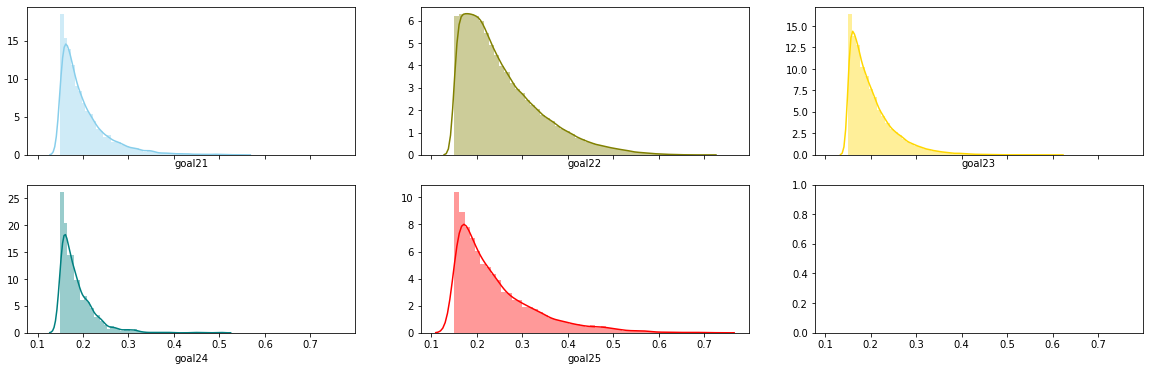

In [0]:
t=.15
f, axes = plt.subplots(2, 3, figsize=(20, 6), sharex=True)
sns.distplot( df["goal21"][df["goal21"]>t] , color="skyblue", ax=axes[0, 0])
sns.distplot( df["goal22"][df["goal22"]>t] , color="olive", ax=axes[0, 1])
sns.distplot( df["goal23"][df["goal23"]>t] , color="gold", ax=axes[0, 2])
sns.distplot( df["goal24"][df["goal24"]>t] , color="teal", ax=axes[1, 0])
sns.distplot( df["goal25"][df["goal25"]>t] , color="red", ax=axes[1, 1]);

## AVG subm2_4_opt_params & subm2_2

In [0]:
subm2_2 = pd.read_csv('/content/drive/My Drive/ottrip_subm/subm2_2.csv')
subm2_4_opt_params = pd.read_csv('/content/drive/My Drive/ottrip_subm/subm2_4_opt_params.csv')

In [0]:
subm2_2[:3]

,Unnamed: 0,goal21,goal22,goal23,goal24,goal25
0,0,0.029837,0.169828,0.000192,0.000070,0.001767
1,1,0.007735,0.034065,0.000059,0.017248,0.008566
2,2,0.104764,0.002281,0.000054,0.206103,0.115626


In [0]:
subm2_4_opt_params[:3]

,Unnamed: 0,goal21,goal22,goal23,goal24,goal25
0,0,0.031965,0.171743,0.000061,0.000040,0.002194
1,1,0.007021,0.033942,0.000020,0.014954,0.009978
2,2,0.115634,0.001444,0.000015,0.196555,0.128621


In [0]:
subm2_AVG1 = ((subm2_2+subm2_4_opt_params)/2).filter(regex='goal')

In [0]:
subm2_AVG1.to_csv( os.path.join(colab_subm_path, 'subm2_AVG1.csv'))

## AVG 2.5 & 2.2  0.739901

In [0]:
PATH = pathlib.Path(colab_subm_path)
s2_5 = pd.read_csv(PATH/'subm2_5.csv')
s2_2 = pd.read_csv(PATH/'subm2_2.csv')
s2_5.shape, s2_2.shape

((455011, 6), (455011, 6))

In [0]:
subm2_AVG2 = s2_5.copy()

In [0]:
subm2_AVG2.goal24 = s2_2.goal24
subm2_AVG2.goal25 = s2_2.goal25
subm2_AVG2[:3]

,Unnamed: 0,goal21,goal22,goal23,goal24,goal25
0,0,0.031965,0.152154,0.000192,0.000070,0.001767
1,1,0.007021,0.029539,0.000059,0.017248,0.008566
2,2,0.115634,0.001854,0.000054,0.206103,0.115626


In [0]:
subm2_AVG2.filter(regex='goal').to_csv( PATH/'subm2_AVG2.csv') # 0.739901

## 2.6 Catboost

In [0]:
Xtrain[:3]

,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,INDICATOR_CNT,USR_CNT,DIFF_H,DIFF_M,CHILD,f14_id_median,f1_id_median,f1_id_std,f14_id_std,f27_id_median,f27_id_std,DAYS_BEFORE_DEPART_id_median,DAYS_BEFORE_DEPART_id_std,NDAYS_FROM_LAST_id_median,NDAYS_FROM_LAST_id_std,field13_id_median,field13_id_std,field26_id_median,field26_id_std,field19_id_median,field19_id_std,field1_sem,field14_sem,field26_sem,field27_sem,field12_sem,NDAYS_FROM_LAST_sem,field13_sem,field22_sem,field25_sem,field1_field14,field26_field27,INDICATOR21_TOTAL_AVG,INDICATOR22_TOTAL_AVG,INDICATOR23_TOTAL_AVG,INDICATOR24_TOTAL_AVG,INDICATOR25_TOTAL_AVG
0,-0.407652,-0.626508,11,12,-0.151820,1,0,1,0,9,-0.354948,-0.125659,-0.661308,1,-0.457289,-0.234311,4,-1.099900,1,1,-0.513581,15,1,-0.333612,-0.446432,1,0,1,1,0,1,1,0.799805,-0.176232,6,1,0,-0.661308,-0.626508,0.000000,0.000000,1.0,0.000000,4.0,0.000000,0.0,0.000000,20.0,0.000000,2.0,0.000000,1.0,0.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.205231,0.934400,0.250000,0.250000,0.000000,0.250000,0.250000
1,1.658223,-0.393794,5,7,-0.096555,0,0,0,0,21,5.739278,-0.418075,-0.101043,1,1.626306,-0.234311,5,-1.099900,6,0,1.108053,15,1,3.107066,-0.211373,1,0,1,1,0,1,0,0.600098,-0.144156,6,2,0,-0.171076,-0.393794,0.000000,0.099042,2.0,1.414214,48.5,12.020815,72.0,101.823376,23.5,28.991378,7.5,6.363961,1.5,0.707107,0.000000,0.070033,4.5,1.0,46.0,72.0,20.5,18.5,5.5,-0.347323,1.184775,0.333333,0.333333,0.000000,0.333333,0.000000
2,1.514759,-0.548937,2,3,-0.096555,0,0,1,1,7,-0.405733,-0.418075,-0.661308,1,-0.457289,-0.234311,2,0.944527,6,0,-0.297364,14,1,-0.333612,1.669100,7,0,1,1,0,1,1,0.799805,-0.144156,7,1,0,-0.661308,-0.587722,0.054851,0.000000,7.0,0.000000,3.5,0.707107,67.0,94.752309,4.0,1.414214,11.0,0.000000,2.0,1.414214,0.038786,0.000000,0.0,0.0,5.0,67.0,1.0,8.0,0.0,-0.249150,-1.569351,0.222222,0.222222,0.111111,0.222222,0.222222


In [0]:
INDIC_AVG = Xtrain.filter(regex='AVG').columns.tolist()

In [0]:
use_cols = Xtrain.columns.difference(INDIC_AVG).tolist()

In [0]:
params_cb = {# 'iterations': 500,
            #  'cat_features': cats_indices,
              'loss_function': 'Logloss',
              'learning_rate': 0.05,
            #  'callbacks': [cat.reset_parameter(learning_rate=learning_rate_005_decay_power_099)],
              # 'eval_metric': 'AUC',
              'task_type': 'GPU',
              'random_seed': SEED,
              # 'logging_level': 'Silent',
              'l2_leaf_reg': 3,
              'bagging_temperature': 0.5,
              'random_strength': 1,
              'one_hot_max_size': 24,
              'leaf_estimation_method': 'Newton',
              'leaf_estimation_iterations': 10,
            #  'per_float_feature_quantization': ['10:border_count=512']
              # 'od_type': 'Iter',
              # 'od_wait': 20,
              # 'use_best_model': False
              #  'depth': 6
          }

goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
df_res = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for col in goals_cols:

    print(f'target: {col}')
    Y = targets[col]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=Xtrain, X_test=Xtest, y=Y, params=params_cb, folds=folds, model_type='cat', eval_metric='auc', 
                                  columns=use_cols, plot_feature_importance=False, model=None,
                                  verbose=500, early_stopping_rounds=200, n_estimators=1200)
   
    df_res[col] = res_dict['prediction'][:, 1]
    df_scores.ix[col, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[col, 'std'] = np.round(np.std(res_dict['scores']), 4)
    
    print(f'{col} completed!')
    print('='*5)

PATH_TO_SAVE=pathlib.Path(colab_subm_path)
df_res.to_csv( PATH_TO_SAVE/'subm2_6_cat_drop_indic.csv' )

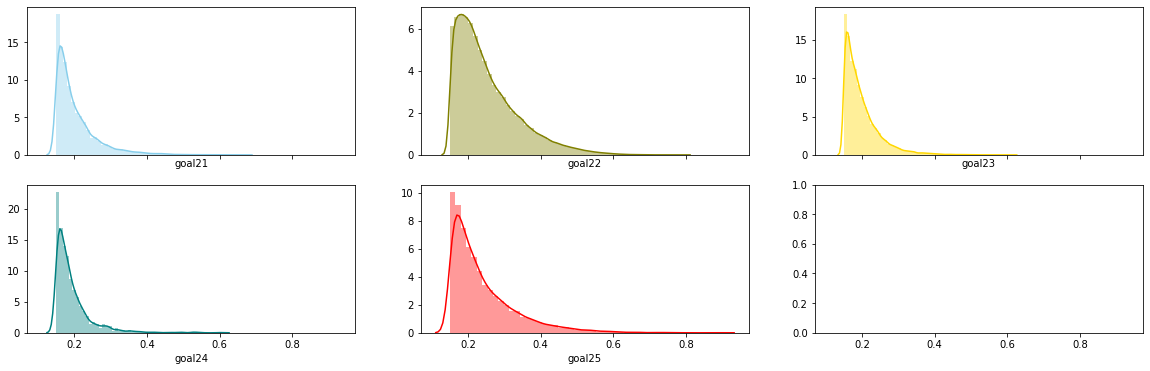

In [0]:
t=.15
f, axes = plt.subplots(2, 3, figsize=(20, 6), sharex=True)
sns.distplot( df_res["goal21"][df_res["goal21"]>t] , color="skyblue", ax=axes[0, 0])
sns.distplot( df_res["goal22"][df_res["goal22"]>t] , color="olive", ax=axes[0, 1])
sns.distplot( df_res["goal23"][df_res["goal23"]>t] , color="gold", ax=axes[0, 2])
sns.distplot( df_res["goal24"][df_res["goal24"]>t] , color="teal", ax=axes[1, 0])
sns.distplot( df_res["goal25"][df_res["goal25"]>t] , color="red", ax=axes[1, 1]);

In [0]:
# without INDICATOR_AVG 0.738664

In [0]:
df_scores # with INDICATOR_AVG # 0.7385770

,avg,std
goal21,0.7392,0.0057
goal22,0.7398,0.0039
goal23,0.9041,0.0043
goal24,0.8101,0.008
goal25,0.938,0.0056


In [0]:
np.array(df_scores.avg).T@ np.array([0.28, 0.27, 0.09, 0.18, 0.18])

0.802749